In [41]:
import os
%matplotlib inline 
from matplotlib import pyplot as plt
from skimage import io, color, exposure
from skimage.transform import rescale
from skimage.filters import unsharp_mask, sato, frangi, hessian
from skimage.morphology import disk
from skimage.filters import rank
from skimage.measure import moments_central, moments_hu
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree.export import export_text
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import accuracy_score
import numpy as np
import cv2
import statistics

from scipy import stats

INPUT = "pictures/Image_05L.jpg"
SCALE = 1

### Additional functions

In [2]:
def showImages(img1, img2, img3):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))

    ax = axes.ravel()

    ax[0].imshow(img1, cmap='gray')
#    ax[0].set_title("Original image")
    
    ax[1].imshow(img2, cmap='gray')
#    ax[1].set_title("Deconvolved, binary")
    
    ax[2].imshow(img3, cmap='gray')
#    ax[2].set_title("Expert")

### Preprocessing

In [3]:
def loadImage(path):
    image = io.imread(path)    
    return image

In [4]:
def scaleImage(image):
    return rescale(image, SCALE, anti_aliasing=True)

In [5]:
def img2grayscale(image):
    return color.rgb2gray(image)

In [6]:
def sharpening(image):
    return unsharp_mask(image, radius=5, amount=2)

In [7]:
def histEq(img):
    return exposure.equalize_adapthist(img, clip_limit=0.01)

In [8]:
def initialProcessing():
    img = loadImage(INPUT)
    #Skalowanie i zamiana na skale szarości
    imgNorm = scaleImage(img2grayscale(img))
    #Wyostrzanie obrazu (lepiej widać naczynia)
    imgSharp = sharpening(imgNorm)
    #Local histogram equalization
    imgEqualized = histEq(imgNorm)
    #Logarithmic gamma adjustment
    imgAdjusted = exposure.adjust_log(imgEqualized, 1)
    showImages(img, imgEqualized, imgAdjusted)
    return (img, imgNorm, imgAdjusted)

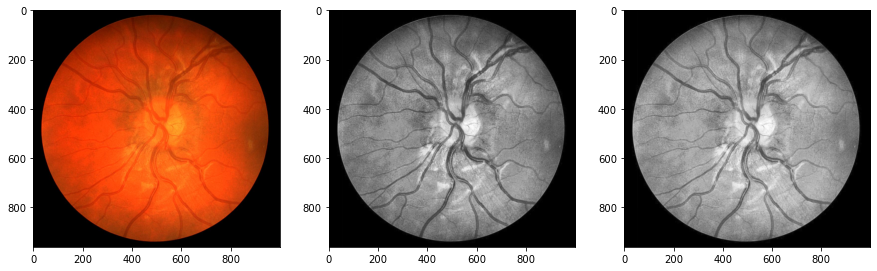

In [9]:
(img, imgNorm, image) = initialProcessing()

### Vessels finding

In [10]:
def detectVessels(image):
    #def frangi(image, sigmas=range(1, 10, 2), scale_range=None, scale_step=None,
    #       beta1=None, beta2=None, alpha=0.5, beta=0.5, gamma=15,
    #       black_ridges=True)
    image = sato(image)
    #image = frangi(image, gamma=0.15)
    return image

In [11]:
def removeWhiteRing(originalImage, binaryImage):
    for iRow, row in enumerate(originalImage):
        for iPx, px in enumerate(row):
            if px < 0.15:
                binaryImage[iRow][iPx] = 0
    return binaryImage

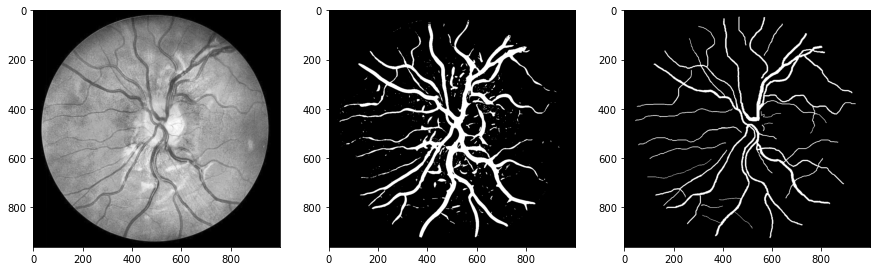

In [12]:
imgVessels = detectVessels(image)

expert = io.imread("pictures/Image_05L_2ndHO.png")
expert = scaleImage(expert)
expert = img2grayscale(expert)

binary = imgVessels > 0.03
binary = binary.astype(int)

expert = expert == 1
expert = expert.astype(int)
removeWhiteRing(imgNorm, binary)
showImages(image, binary, expert)

### Visualization

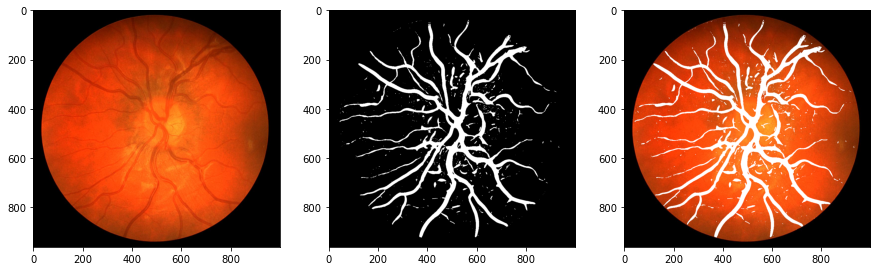

In [13]:
def visualize(originalImage, binaryImage):
    for iRow, row in enumerate(binaryImage):
        for iPx, px in enumerate(row):
            if px == 1:
                originalImage[iRow][iPx] = [255, 255, 255]
    return originalImage

visualized = visualize(img.copy(), binary)
showImages(img, binary, visualized)

### Check correctness

In [14]:
sizeX, sizeY = len(image), len(image[0])

image_positives = int(np.sum(binary))
image_negatives = sizeX * sizeY - image_positives

sizeX, sizeY = len(expert), len(expert[0])

expert_positives = int(np.sum(expert))
expert_negatives = sizeX * sizeY - expert_positives

print(image_positives)
print(image_negatives)

print(expert_positives)
print(expert_negatives)

106709
852331
55425
903615


In [15]:
combination = binary * expert

# TP - correctly classified as positive
# TN -  correctly classified as negative
# FP - incorrectly classified as positive
# FN - incorrectly classified as negative

TP = int(np.sum(combination))
print("Prawdziwie pozytywna: ", TP)

FP = image_positives - TP
print("Fałszywie pozytywna: ", FP)

TN = expert_negatives - FP
print("Prawdziwie negatywna: ", TN)

FN = expert_positives - TP
print("Fałszywie negatywna: ", FN)


Prawdziwie pozytywna:  48258
Fałszywie pozytywna:  58451
Prawdziwie negatywna:  845164
Fałszywie negatywna:  7167


In [16]:
sensitivity = TP / (TP + FN)
print("Czułość: ", sensitivity)

specificity = TN / (TN + FP)
print("Swoistość: ", specificity)

accuracy = (TN + TP) / (TN + TP + FN + FP)
print("Trafność: ", accuracy)

Czułość:  0.8706901217861975
Swoistość:  0.9353142654781074
Trafność:  0.9315794961628295


## 5.0

### Splitting into pieces

In [17]:
class Piece:
    def __init__(self, array, isVessel):
        self.array = array
        self.countVariance()
        self.countCentralMoments()
        self.countHuMoments()
        self.isVessel = 1 if isVessel else 0
    
    def countVariance(self):
        self.variance = statistics.variance(self.array.flatten())
    
    #Computing mean of moments - is it good?
    def countCentralMoments(self):
        moments = moments_central(self.array)
        self.centralMoment = statistics.mean([*map(statistics.mean, zip(*moments))])
        
    def countHuMoments(self):
        moments = moments_hu(self.array)
        self.huMoment = statistics.mean(moments)

In [18]:
def sliceImage(image, mask, pixels):
    middle = int(pixels/2)
    pieces = []
    width = len(image[0])
    height = len(image)
    pieces = []
    for row in range(0, height, pixels):
        for col in range(0, width, pixels):
            #Is middle pixel of mask vessel or not
            if (mask[row:row+pixels,col:col+pixels][middle][middle] == 1): isVessel = True
            else: isVessel = False
            pieces.append(Piece(image[row:row+pixels,col:col+pixels], isVessel))
    return pieces

In [19]:
pieces = sliceImage(image, expert, 5)

In [20]:
def extractDataForClassifier(pieces):
    # moments, variance, etc
    values = []
    # is vessel or not?
    labels = []
    for piece in pieces:
        values.append([piece.variance, piece.centralMoment, piece.huMoment])
        labels.append(piece.isVessel)
    return (values, labels)

In [45]:
#X - list of lists of moments, variances, etc
#y - labels - vessel  or not
X, y = extractDataForClassifier(pieces)

### Cross Validation


In [22]:
#UWAGA!! TUTAJ
#1. dlaczego test_size=0.3?
#2. ten random_state wgl jest potrzebny? czytam, że jak jest None, to po prostu przyjmuje wartość np.random
# Potem trzeba będzie to wyjaśnić, wiec warto mieć jakiś powód, dlaczego właśnie tyle

#Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

In [23]:
#TUTAJ
# to wygląda spoko, jak dla mnie

#Feeding classifier
decisionTree = DecisionTreeClassifier()
decisionTree = decisionTree.fit(X_train, y_train)

In [24]:
#I TUTAJ - obliczany jest "prosty" cross-validation, nie wiem czy ma być tak jak w tych trzech komórkach, czy tak jak
# w następnej
# jest git - rozumiem, że cv możemy sobie dopasować, jak tylko chcemy. Można to zrobić jako jakaś stała na początku

#cv - how many times score is counted
scores = cross_val_score(decisionTree, X_test, y_test, cv=5)

In [43]:
# KFold Cross Validation approach
kf = KFold(n_splits=5,shuffle=False)
kf.split(X)
     
# Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
accuracy_model = []

# EDIT: tej pętli tu w sumie trochę nie ogarniam, ale ufam, że wiesz, co się dzieje xD
# poczytam jeszcze nt. tego KFold, ale widzę, że analogiczny przykład jest na stronie, wiec wygląda legitnie
    
# Iterate over each train-test split
for train_index, test_index in kf.split(X):
    # Split train-test
    X_train, X_test = X[train_index[0]:train_index[-1]], X[test_index[0]:test_index[-1]]
    y_train, y_test = y[train_index[0]:train_index[-1]], y[test_index[0]:test_index[-1]]
    # Train the model
    model = decisionTree.fit(X_train, y_train)
    # Append to accuracy_model the accuracy of the model
    accuracy_model.append(accuracy_score(y_test, model.predict(X_test), normalize=True)*100)

In [44]:
#EDIT: nie czaje tylko, dlaczego takie wyniki, hm
# bo tj rozumiem stopień, jak dobrze dopasowuje tak? dlaczego na środku jest 3 razy 100%?

print(accuracy_model)

[88.08438598775882, 100.0, 100.0, 100.0, 94.67378564917307]
